In [1]:
import sys
sys.path.append('..')

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from cleansing.data_cleansing import preprocess_data
import numpy as np

X_train, X_test, y_train, y_test = preprocess_data()

# LightGBM 데이터셋으로 변환
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

# LightGBM 모델 설정
params = {
    'objective': 'regression',
    'metric': ['rmse', 'mae'], # 'set' 대신 'list'로 변경
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 6,
    'min_child_weight': 0.1,
    'verbosity': -1
}

# 모델 학습
num_round = 100
bst = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_train, lgb_eval], early_stopping_rounds=10, verbose_eval=0)

# 모델 예측
y_pred_lgb = bst.predict(X_test, num_iteration=bst.best_iteration)

# 예측값과 실제값의 MSE 계산
mse = mean_squared_error(y_test, y_pred_lgb)
print("MSE:", mse)

plt.rcParams['font.family'] = 'AppleGothic'

# 모델 feature importance 출력
lgb.plot_importance(bst)
plt.show()

TypeError: can't subtract offset-naive and offset-aware datetimes

In [11]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

X_train, X_test, y_train, y_test = preprocess_data()

# LightGBM 데이터셋으로 변환
lgb_train = lgb.Dataset(X_train, label=y_train)

# 하이퍼파라미터 공간 설정
param_dist = {
    'num_leaves': sp_randint(10, 500),
    'learning_rate': sp_uniform(loc=0.01, scale=0.1),
    'feature_fraction': sp_uniform(loc=0.5, scale=0.5),
    'bagging_fraction': sp_uniform(loc=0.5, scale=0.5),
    'bagging_freq': sp_randint(1, 10),
    'max_depth': sp_randint(3, 15),
    'min_child_weight': sp_uniform(loc=0, scale=1),
    'metric': ['mae', 'rmse']
}

# LightGBM 모델 설정
lgb_model = lgb.LGBMRegressor(n_jobs=-1)

# RandomizedSearchCV 수행
random_search = RandomizedSearchCV(
    lgb_model, param_distributions=param_dist, n_iter=100,
    scoring='neg_mean_squared_error', cv=5, n_jobs=-1, random_state=42
)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
# 최적의 하이퍼파라미터 출력
bst_cv = lgb.train(best_params, lgb_train)

# 학습된 모델을 이용해 테스트 데이터셋의 예측값 뽑아내기
y_pred_cv = bst_cv.predict(X_test)

mse = mean_squared_error(y_test, y_pred_cv)
print("MSE:", mse)

/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.6872700594236812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6872700594236812[LightGBM] [Warning] bagging_fraction is set=0.6872700594236812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6872700594236812[LightGBM] [Warning] bagging_fraction is set=0.6872700594236812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6872700594236812


[LightGBM] [Warning] feature_fraction is set=0.7993292420985183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7993292420985183
[LightGBM] [Warning] feature_fraction is set=0.7993292420985183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7993292420985183[LightGBM] [Warning] feature_fraction is set=0.7993292420985183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7993292420985183

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagg

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MSE: 0.010748407356381762


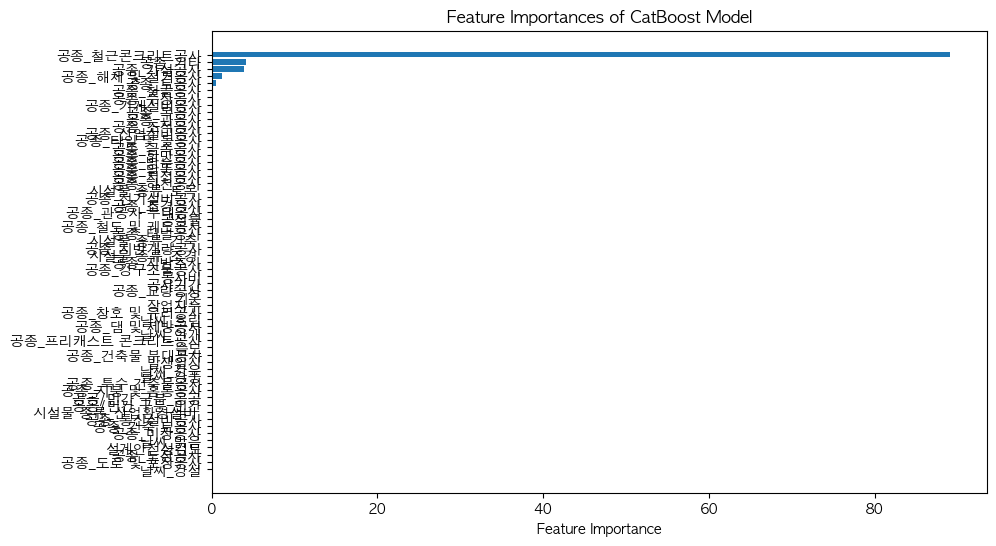

In [2]:
import catboost as cb
from sklearn.metrics import mean_squared_error

# CatBoost 데이터셋으로 변환
cb_train = cb.Pool(X_train, label=y_train)
cb_eval = cb.Pool(X_test, label=y_test)

# 모델 학습
model = cb.CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    learning_rate=0.05,
    iterations=1000,
    depth=6,
    l2_leaf_reg=3,
    random_seed=42
)
model.fit(cb_train, eval_set=cb_eval, early_stopping_rounds=10, verbose=0, plot=True)

# 모델 예측
y_pred_cb = model.predict(X_test)

# 예측값과 실제값의 MSE 계산
mse = mean_squared_error(y_test, y_pred_cb)
print("MSE:", mse)

# 특성 중요도
feature_importances = model.get_feature_importance(cb_train)

# 특성 이름
feature_names = X_train.columns

# 특성 중요도를 내림차순으로 정렬
sorted_idx = feature_importances.argsort()

# 특성 중요도를 내림차순으로 정렬된 순서로 정렬
feature_names_sorted = feature_names[sorted_idx]
feature_importances_sorted = feature_importances[sorted_idx]

# 특성 중요도 그래프 그리기
plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), feature_importances_sorted, align='center')
plt.yticks(range(X_train.shape[1]), feature_names_sorted)
plt.xlabel('Feature Importance')
plt.title('Feature Importances of CatBoost Model')
plt.show()



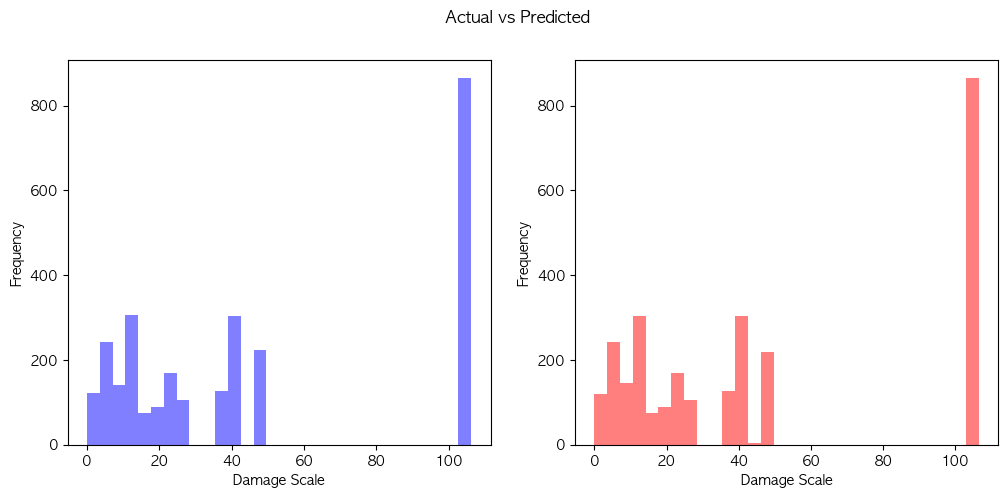

In [3]:
# 모델 예측값과 y 레이블의 정답값 분포 시각화
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 예측값과 실제값의 분포 시각화
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Actual vs Predicted')

# y_test 히스토그램
axs[0].hist(y_test, bins=30, alpha=0.5, color='blue', label='Actual')
axs[0].set_xlabel('Damage Scale')
axs[0].set_ylabel('Frequency')

# y_pred_lgb 히스토그램
axs[1].hist(y_pred_cb, bins=30, alpha=0.5, color='red', label='Predicted')
axs[1].set_xlabel('Damage Scale')
axs[1].set_ylabel('Frequency')

plt.show()



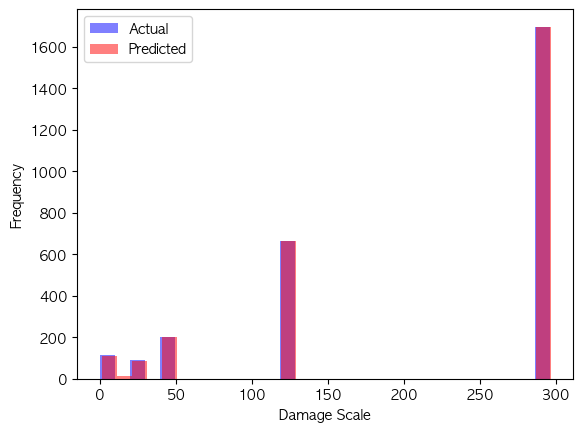

In [4]:
fig, ax = plt.subplots()
ax.hist(y_test, bins=30, alpha=0.5, color='blue', label='Actual')
ax.hist(y_pred_lgb, bins=30, alpha=0.5, color='red', label='Predicted')
ax.set_xlabel('Damage Scale')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()


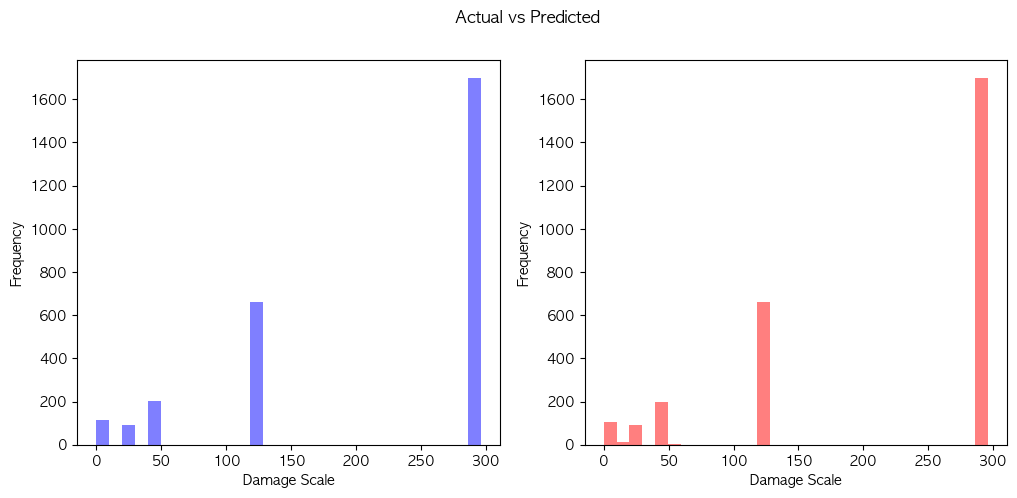

In [9]:
# 모델 예측값과 y 레이블의 정답값 분포 시각화
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 예측값과 실제값의 분포 시각화
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Actual vs Predicted')

# y_test 히스토그램
axs[0].hist(y_test, bins=30, alpha=0.5, color='blue', label='Actual')
axs[0].set_xlabel('Damage Scale')
axs[0].set_ylabel('Frequency')

# y_pred_lgb 히스토그램
axs[1].hist(y_pred_cb, bins=30, alpha=0.5, color='red', label='Predicted')
axs[1].set_xlabel('Damage Scale')
axs[1].set_ylabel('Frequency')

plt.show()



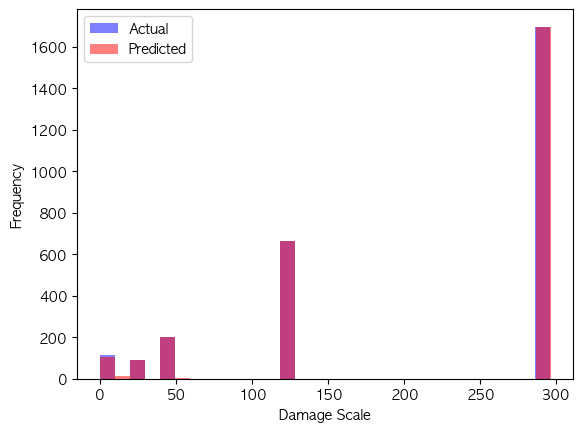

In [10]:
fig, ax = plt.subplots()
ax.hist(y_test, bins=30, alpha=0.5, color='blue', label='Actual')
ax.hist(y_pred_cb, bins=30, alpha=0.5, color='red', label='Predicted')
ax.set_xlabel('Damage Scale')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()


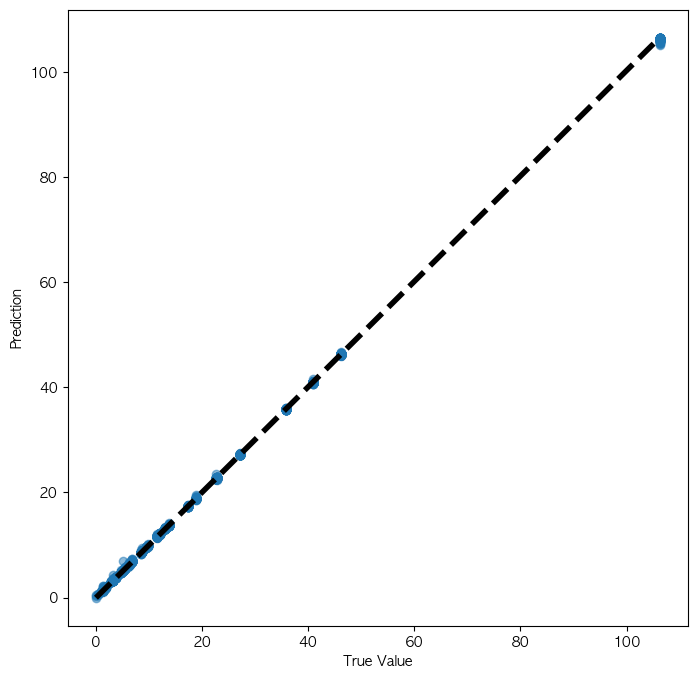

In [4]:
import matplotlib.pyplot as plt

# 예측값과 실제값 비교
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_cb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_pred_cb.min(), y_pred_cb.max()], 'k--', lw=4)
plt.xlabel('True Value')
plt.ylabel('Prediction')
plt.show()


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# y_test: 실제 값, prediction: 예측 값
accuracy = np.sum(np.abs(y_test['공종별 위험도 평가지수'].values - y_pred_cb) <= 0.1) / len(y_test)

print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 85.94%


In [10]:
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import mean_squared_error

# RMSE 계산
rmse_lgb = mean_squared_error(y_test, y_pred_lgb, squared=False)
rmse_cb = mean_squared_error(y_test, y_pred_cb, squared=False)

# 결과 출력
print("LGBM RMSE:", rmse_lgb)
print("CatBoost RMSE:", rmse_cb)


LGBM RMSE: 1.7536912467433785
CatBoost RMSE: 0.1036745260726171


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

predictions = y_pred_lgb

# y_test: 실제 값, prediction: 예측 값
accuracy = np.sum(np.abs(y_test['공종별 위험도 평가지수'].values - predictions) <= 0.1) / len(y_test)

print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 5.28%
